# OBJECT DETECTION BASED ON CAPTION WITH YOLOv3
## in this project, we try to find objects in images base on the caption these pictures have.

###  using pre traind model of yolo v3.
   #### to do so, first we make our model then we apply the downloaded weights.
   
## MAKING THE MODEL:
##### based on https://github.com/experiencor/keras-yolo3

<span style='color:red'> you dont need to run this block! </span>

In [14]:

# create a YOLOv3 Keras model and save it to file
# based on https://github.com/experiencor/keras-yolo3
import structusing
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers import add, concatenate
from keras.models import Model
 
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']),
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
    return add([skip_connection, x]) if skip else x
 
def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))
    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    skip_36 = x
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
    skip_61 = x
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])
    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])
    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
    model = Model(input_image, [yolo_82, yolo_94, yolo_106])
    return model
 
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))
            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)
            transpose = (major > 1000) or (minor > 1000)
            binary = w_f.read()
        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
 
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
         
    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))
                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))
                    size = np.prod(norm_layer.get_weights()[0].shape)
                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance
                    weights = norm_layer.set_weights([gamma, beta, mean, var])
                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))
 
    def reset(self):
        self.offset = 0
 
# define the model
model = make_yolov3_model()
# load the model weights
weight_reader = WeightReader('yolov3.weights')
# set the model weights into the model
weight_reader.load_weights(model)
# save the model to file
model.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

### After saving the model we can reuse it just by reading the <span style='color:green'>'model.h5'</span> file that we saved.

In [226]:
from numpy import expand_dims
from keras.models import load_model
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

model = load_model('model.h5')

### some of the usual function that will be use to load the image and also to <span style='color:green'>draw the boxes</span> around the objects.

In [227]:
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

In [228]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
 
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
 
        return self.label
 
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
 
        return self.score
 
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [229]:
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

In [230]:
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    # show the plot
    pyplot.show()

### by calling this function below we can detect objects in a image with Yolov3

In [231]:
import numpy as np
def my_predct(photo_filename):
    labels =["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
    anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
    # define the probability threshold for detected objects
    class_threshold = 0.6
    input_w, input_h = 416, 416
    image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
    yhat = model.predict(image)
    boxes = list()
    for i in range(len(yhat)):
        # decode the output of the network
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
    # correct the sizes of the bounding boxes for the shape of the image
    correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
    # suppress non-maximal boxes
    do_nms(boxes, 0.5)
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    # summarize what we found
    for i in range(len(v_boxes)):
        print(v_labels[i], v_scores[i])
    draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

### some examples:

1/1 [==============================] - 2s 2s/step
person 98.62275719642639


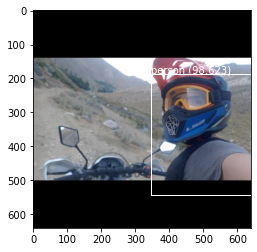

In [232]:
my_predct('photo_۲۰۲۲-۰۸-۱۰_۲۰-۲۲-۵۸.jpg')

1/1 [==============================] - 0s 324ms/step
person 99.38233494758606
person 91.6433036327362
person 83.71272087097168
person 99.94226098060608
person 99.5434820652008
person 99.93520379066467


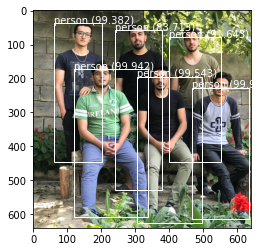

In [233]:
my_predct('photo_۲۰۲۰-۱۰-۰۷_۲۱-۲۷-۳۹.jpg')

## Now we need to process the captions of images and extract the objects mentioned in them.

In [256]:
# import nltk
# nltk.download('stopwords')
# nltk.download("wordnet")
# nltk.download("omw-1.4")

In [235]:
Yolo_labels =["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

### creating some alternative words for objects recognized by Yolo
#### usnig synonyms in nltk library and Manual adding

In [486]:
synsets_of_Yolo_labels = [wordnet.synsets(x) for x in Yolo_labels]

In [487]:
import nltk
from nltk.corpus import wordnet

label_synonyms_dict = {}
synonyms = []
for index,wordnetInstance in enumerate(synsets_of_Yolo_labels):
    label_synonyms_dict[Yolo_labels[index]] = []
    for syn in wordnetInstance:
        for l in syn.lemmas():
            synonyms.append(l.name())
            label_synonyms_dict[Yolo_labels[index]].append(l.name())

# ------- MANUAL ADDING ----------------
# label_synonyms_dict["person"].append('people','me','him','I','sir'])
label_synonyms_dict["person"] += ['people','me','him','i','sir','friend','girl', 'boy','man' , 'woman']


print(label_synonyms_dict["person"])

['person', 'individual', 'someone', 'somebody', 'mortal', 'soul', 'person', 'person', 'people', 'me', 'him', 'i', 'sir', 'friend', 'girl', 'boy', 'man', 'woman']


### creating a dictionary:  key: yolo objcet  value: altenative words 

In [454]:
for key, value in label_synonyms_dict.items():
    if key not in value:
        label_synonyms_dict[key].append(key)


### tokenizing and lemmatizing the captions

In [456]:
# nltk.download('words')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [455]:
from nltk import sent_tokenize, word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
def clean_text(text):
    """
    This function takes as input a text on which several 
    NLTK algorithms will be applied in order to preprocess it
    """
    tokens = word_tokenize(text)
    # Remove the punctuations
    tokens = [word for word in tokens if word.isalpha()]
    # Lower the tokens
    tokens = [word.lower() for word in tokens]
    # Remove stopword
#     tokens = [word for word in tokens if not word in stopwords.words("english")]
    # Lemmatize
    
    tmp_tokens = tokens.copy()
    lemma = WordNetLemmatizer()
    #tokens = [lemma.lemmatize(word, pos = "v") for word in tokens]
    tokens = [lemma.lemmatize(word, pos = "n") for word in tokens]
    
    dict_map = {}
    for i in range(len(tmp_tokens)):
        dict_map[tokens[i]]=tmp_tokens[i]
    
    return tokens , dict_map

### creating a sample dataset

In [488]:
import numpy as np
import pandas as pd
def readTable():
    data = {
      "imagePath": ['photo1629634995.jpeg', 'photo_۲۰۲۲-۰۸-۱۰_۲۰-۲۲-۵۸.jpg', 'photo_۲۰۲۰-۱۰-۰۷_۲۱-۲۷-۳۹.jpg','photo_۲۰۲۲-۰۶-۱۸_۰۰-۲۶-۲۳.jpg'],
      "caption": ["I love bicycles", "me and my motorbike", "bunch of people and me",'me and my motorbike']
    }

    df = pd.DataFrame(data)
    for key, value in label_synonyms_dict.items():
        df[key]=0
    return df

### one hot encoding for each label in yolo
1 := mentioned in caption

0 := not mentioned in caption

In [478]:
def updateTable():
    df = readTable() # reset dataset
    dict_map = {}
    for row in range(df.shape[0]):
        
        tokens , dict_tmp = clean_text(df.loc[[row]]['caption'].to_string())
        for key, values in label_synonyms_dict.items():    
            for value in values:
                
                flag = False          
                if value in tokens:   
                    
                    df.at[row,key]=1
                    dict_tmp[key] = dict_tmp.pop(value)
                    dict_map[row] = dict_tmp
                    flag = True
                    
                if flag :
                    break
    return df , dict_map

In [479]:
df , dict_map = updateTable()
df

,imagePath,caption,person,bicycle,car,motorbike,aeroplane,bus,train,truck,...,toaster,sink,refrigerator,book,clock,vase,scissors,teddy bear,hair drier,toothbrush
0,photo1629634995.jpeg,I love bicycles,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,photo_۲۰۲۲-۰۸-۱۰_۲۰-۲۲-۵۸.jpg,me and my motorbike,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,photo_۲۰۲۰-۱۰-۰۷_۲۱-۲۷-۳۹.jpg,bunch of people and me,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,photo_۲۰۲۲-۰۶-۱۸_۰۰-۲۶-۲۳.jpg,me and my motorbike,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### dict_map is a python dectionary that we will use to remembering the words in caption that we detect as an mentioned object
key = row in dataset

value = dict (label:word)

In [480]:
dict_map

{0: {'person': 'i', 'bicycle': 'bicycles', 'bed': 'love'},
 1: {'and': 'and', 'my': 'my', 'person': 'me', 'motorbike': 'motorbike'},
 2: {'bunch': 'bunch',
  'of': 'of',
  'and': 'and',
  'me': 'me',
  'person': 'people'},
 3: {'and': 'and', 'my': 'my', 'person': 'me', 'motorbike': 'motorbike'}}

In [481]:
for key1, values in dict_map.items():   
    tmp_dict = dict_map[key1].copy()
    print(tmp_dict)
    for key2, values2 in tmp_dict.items():
        if key2 not in Yolo_labels:
            dict_map[key1].pop(key2)
dict_map

{'person': 'i', 'bicycle': 'bicycles', 'bed': 'love'}
{'and': 'and', 'my': 'my', 'person': 'me', 'motorbike': 'motorbike'}
{'bunch': 'bunch', 'of': 'of', 'and': 'and', 'me': 'me', 'person': 'people'}
{'and': 'and', 'my': 'my', 'person': 'me', 'motorbike': 'motorbike'}


{0: {'person': 'i', 'bicycle': 'bicycles', 'bed': 'love'},
 1: {'person': 'me', 'motorbike': 'motorbike'},
 2: {'person': 'people'},
 3: {'person': 'me', 'motorbike': 'motorbike'}}

In [482]:
def my_predct2(photo_filename, wanted_labels,row):
    anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
    # define the probability threshold for detected objects
    class_threshold = 0.6
    input_w, input_h = 416, 416
    image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
    yhat = model.predict(image)
    boxes = list()
    for i in range(len(yhat)):
        # decode the output of the network
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
    # correct the sizes of the bounding boxes for the shape of the image
    correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
    # suppress non-maximal boxes
    do_nms(boxes, 0.5)
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    # summarize what we found
    indexes = []
    for i in range(len(v_labels)):
        
        if v_labels[i] not in wanted_labels:
            indexes.append(i)
        else:
            v_labels[i]= dict_map[row][v_labels[i]]
    tmp_v_boxes = v_boxes.copy()
    tmp_v_labels = v_labels.copy()
    tmp_v_scores = v_scores.copy()
    
    for i in indexes:
            v_boxes.remove(tmp_v_boxes[i])
            v_labels.remove(tmp_v_labels[i])
            v_scores.remove(tmp_v_scores[i])
            
    for i in range(len(v_boxes)):
        print(v_labels[i], v_scores[i])
    draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

In [505]:
def final_predict_from_dataset(number):
    for row,imgPath in  enumerate(df['imagePath']):
        if number == 0:
            break
        print('IMAGE PATH:         ',imgPath)
        print('ROW INDEX:          ',row)
        list_of_labels = list(df.loc[[row]][list(df.columns[2:])])
        wanted_labels = []
        for i in range(len(list_of_labels)):
            if int(df.loc[[row]][list_of_labels[i]]) == 1:
                wanted_labels.append(df.loc[[row]][list_of_labels[i]].name)
        print('CAPTOIN:            ',df.loc[[row]]['caption'].values[0])
        print('MENTIONED OBJECTS:  ',wanted_labels)
        my_predct2(imgPath,wanted_labels,row)
        number -= 1


## sample results:

IMAGE PATH:          photo1629634995.jpeg
ROW INDEX:           0
CAPTOIN:             I love bicycles
MENTIONED OBJECTS:   ['person', 'bicycle', 'bed']
1/1 [==============================] - 0s 398ms/step
bicycles 99.50585961341858


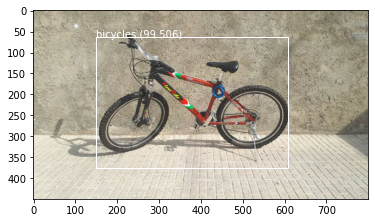

IMAGE PATH:          photo_۲۰۲۲-۰۸-۱۰_۲۰-۲۲-۵۸.jpg
ROW INDEX:           1
CAPTOIN:             me and my motorbike
MENTIONED OBJECTS:   ['person', 'motorbike']
1/1 [==============================] - 0s 351ms/step
me 98.62275719642639


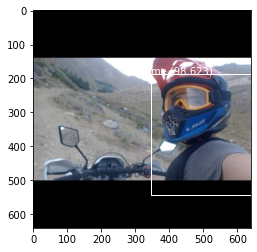

IMAGE PATH:          photo_۲۰۲۰-۱۰-۰۷_۲۱-۲۷-۳۹.jpg
ROW INDEX:           2
CAPTOIN:             bunch of people and me
MENTIONED OBJECTS:   ['person']
1/1 [==============================] - 0s 361ms/step
people 99.38233494758606
people 91.6433036327362
people 83.71272087097168
people 99.94226098060608
people 99.5434820652008
people 99.93520379066467


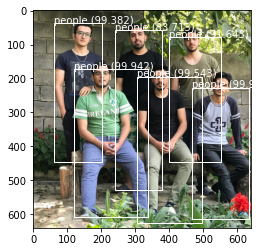

IMAGE PATH:          photo_۲۰۲۲-۰۶-۱۸_۰۰-۲۶-۲۳.jpg
ROW INDEX:           3
CAPTOIN:             me and my motorbike
MENTIONED OBJECTS:   ['person', 'motorbike']
1/1 [==============================] - 0s 342ms/step
motorbike 99.88669753074646
me 99.88911747932434


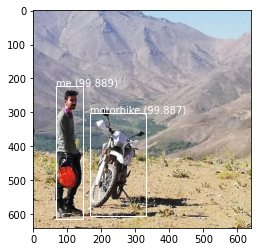

In [506]:
final_predict_from_dataset(4)